# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Weight-Estimation" data-toc-modified-id="Weight-Estimation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Weight Estimation</a></div><div class="lev2 toc-item"><a href="#Algorithm-Setup" data-toc-modified-id="Algorithm-Setup-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Algorithm Setup</a></div><div class="lev2 toc-item"><a href="#Open-Raw-Data-File-(Synthetic)" data-toc-modified-id="Open-Raw-Data-File-(Synthetic)-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Open Raw Data File (Synthetic)</a></div><div class="lev2 toc-item"><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev2 toc-item"><a href="#Speed-estimation" data-toc-modified-id="Speed-estimation-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Speed estimation</a></div><div class="lev2 toc-item"><a href="#Wave-Curve-extration" data-toc-modified-id="Wave-Curve-extration-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Wave Curve extration</a></div><div class="lev2 toc-item"><a href="#Weight-estimation" data-toc-modified-id="Weight-estimation-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Weight estimation</a></div><div class="lev3 toc-item"><a href="#Estimation-by-Peak-Voltage" data-toc-modified-id="Estimation-by-Peak-Voltage-161"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Estimation by Peak Voltage</a></div><div class="lev3 toc-item"><a href="#Estimation-by-Area-under-the-signal" data-toc-modified-id="Estimation-by-Area-under-the-signal-162"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Estimation by Area under the signal</a></div><div class="lev3 toc-item"><a href="#Estimation-by-Re-sampling-of-area" data-toc-modified-id="Estimation-by-Re-sampling-of-area-163"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Estimation by Re-sampling of area</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>References</a></div>

# Weight Estimation

Weight estimation can differ respectively of the technology.

## Algorithm Setup

In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
from scipy import integrate

import numpy as np
import pandas as pd
import peakutils
import sys

# local
sys.path.insert(0, '../')

from pywim.estimation.speed import speed_by_peak
from pywim.utils import storage
from pywim.utils.dsp import wave_curve
from pywim.utils.stats import iqr

## Open Raw Data File (Synthetic)

METADATA
sample_rate:         	2000
date_time:           	2017-28-24 23:28:45
site_id:             	001
lane_id:             	01
temperature:         	28.5
license_plate:       	AAA9999
calibration_constant:	[ 0.98  0.99  0.75]
sensors_distance:    	[0 1 2]
sensor_type:         	mixed
sensors_layout:      	|||
channel_configuration:	{"a1": "ceramic", "a0": "polymer", "a2": "polymer"}


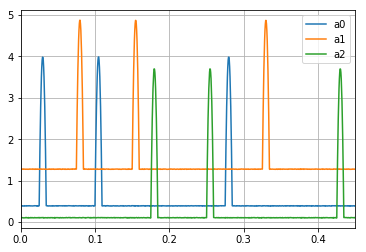

In [2]:
f = storage.open_file('../data/wim_day_001_01_20170324.h5')

dset = f[list(f.keys())[0]]
df = storage.dataset_to_dataframe(dset)

# information on the file
paddle = len(max(dset.attrs, key=lambda v: len(v)))

print('METADATA')
print('='*80)
for k in dset.attrs:
    print('{}:'.format(k).ljust(paddle, ' '), dset.attrs[k], sep='\t')

df.plot()
plt.grid(True)
plt.show()

## Data cleaning

######## use information from data cleaning report

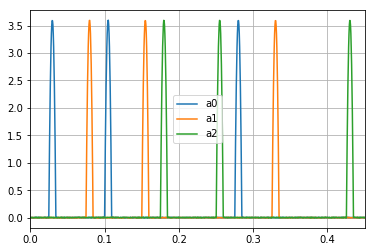

In [3]:
data_cleaned = df.copy()

for k in data_cleaned.keys():
    # use the first 10 points as reference to correct the baseline
    # in this case should work well
    data_cleaned[k] -= data_cleaned[k].values[:10].mean()

data_cleaned.plot()
plt.grid(True)
plt.show()

## Speed estimation

In [4]:
# calculates the speed for each pair of sensors by axles
speed = speed_by_peak.sensors_estimation(
    data_cleaned, dset.attrs['sensors_distance']
)

display(speed)

[array([ 19.78000242,  20.17959843,  20.17959843]),
 array([ 19.78000242,  20.17959843,  20.17959843]),
 array([ 20.07819341,  19.97780244,  19.97780244])]

## Wave Curve extration

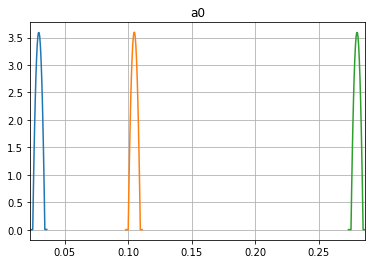

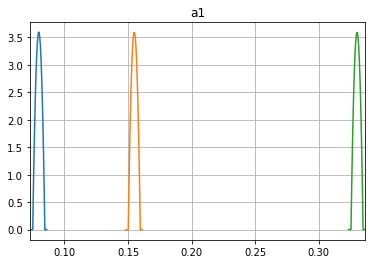

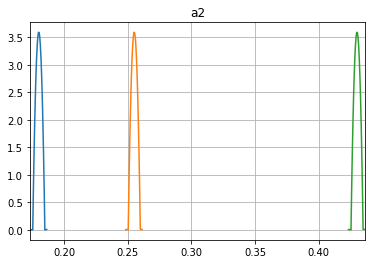

In [5]:
curves = []

for k in data_cleaned.keys():
    curves.append(
        wave_curve.select_curve_by_threshold(
            data_cleaned[k], threshold=1, delta_x=5
        )
    )
    
    for c in curves[-1]: 
        # plot each axle measured
        c.plot()
        
    plt.grid(True)
    plt.title(k)
    plt.show()

## Weight estimation

\cite{kwon2007development} presents three approach about weight estimation: 

* Peak voltage;
* Area under the signal;
* Re-sampling of area (proposed method).

In this study, these three methods will be implemented.

### Estimation by Peak Voltage

According to \cite{kwon2007development}, the peak voltage generated by the 
same vehicle does not change for different speeds, however, this assumption is 
incorrect since the peak will change if tire inflation pressure is not 
constant. So, this method can be very helpful when accuracy is not important.

The equation presented in that study is:

\begin{equation}\label{eq:weigh_by_peak}
w = \alpha * peak\_signal\_voltage(x_i)
\end{equation}


where:

* peak_signal_voltage($x_i$) is the peak voltage value of the digitized  signal x(t); 
* and α is a calibration factor which must be determined using a known axle load.

In [6]:
def weigh_by_peak_signal_voltage(peaks: [float], cs: [float]):
    """
    :param peaks: peak signal voltage array
    :type peaks: np.array
    :param cs: calibration factor array
    :type cs: np.array
    :returns: np.array
    """
    return np.array(peaks * cs)

In [7]:
x = data_cleaned.index.values

for k in data_cleaned.keys():
    y = data_cleaned[k].values
    
    indexes = peakutils.indexes(y, thres=0.5, min_dist=30)
    
    # calibration given by random function
    c = np.random.randint(900, 1100, 1)
    w = weigh_by_peak_signal_voltage(y[indexes], c)
    
    print(k, w)

a0 [ 3927.35001557  3933.78029975  3927.41498169]
a1 [ 3603.77972989  3600.298424    3599.20638889]
a2 [ 3622.11373441  3621.32165967  3620.2534338 ]


### Estimation by Area under the signal

\cite{kwon2007development} presented the axle load computation method recommended 
by Kistler \cite{kistler2004installation} that computes the axle loads using the area 
under the signal curve and the speed of the vehicle traveling. A typical signal curve 
can be viewed as:

\begin{figure}
\centerline{\includegraphics[width=10cm]{img/kistler-signal.png}}
\caption{\label{fig:kistler-signal} Raw data signal illustration. Source \cite{kistler2004installation}}
\end{figure}


The equation 
presented by Kistler \cite{kistler2004installation} is:


\begin{equation}\label{eq:weigh_by_area_under_the_signal_1}
    W = \frac{V . C}{L} . \int_{t_2+\Delta t}^{t_1 - \Delta t} (x(t) − b(t)) dt
\end{equation}

where: 

* t1 and t2 are point where threshold touches on the start and the end of the signal;
* $\Delta$t is an average value from t1 and t2 to the point when the signal is near to the baseline;
* C is a constant calibration factor;
* L is the sensor width;
* V is the speed (velocity) of the vehicle;
* x(t) is the load signal;
* b(t) is the baseline level. 

Also, there is a digital form as:

\begin{equation}\label{eq:weigh_by_area_under_the_signal_2}
W = \frac{V . C}{L} . \sum(x_i-b_i)
\end{equation}

In [8]:
load = []

t = 1/dset.attrs['sample_rate']

print('t = ', t)

for axles_curve in curves:
    # composite trapezoidal rule
    load.append([
        integrate.trapz(v, dx=t)
        for v in axles_curve
    ])
    
print('\nLoad estimation:')
display(load)

t =  0.0005

Load estimation:


[[0.022763645524943973, 0.022756955104362531, 0.022764238944630106],
 [0.022737690086881611, 0.022724775631087657, 0.022731572497871701],
 [0.02274340714467794, 0.022763309778475037, 0.02276563032674082]]

In [9]:
# W = (v/L) * A * C
v = speed
a = load
l = 0.053  # sensor width
c = dset.attrs['calibration_constant']
w = []

for i, _load in enumerate(load):
    # sensor data
    _w = []
    for j in range(len(_load)):
        # axle data
        _w.append((v[i][j]/l) * a[i][j] * c[i])
    w.append(_w)
    
weight = np.matrix(w)

print('Axle estimated weight by each sensor:')
display(weight)

weight_axles = []

for i in range(weight.shape[0]):
    v = pd.Series(weight[:, i].view(np.ndarray).flatten())
    weight_axles.append(iqr.reject_outliers(v).mean())
    
print('Axle estimated weight:')
display(weight_axles)

gvw = sum(weight_axles)

print('Gross Vehicle Weigh:', gvw)

Axle estimated weight by each sensor:


matrix([[ 8.32565404,  8.49135266,  8.4940705 ],
        [ 8.4010198 ,  8.5658694 ,  8.56843141],
        [ 6.46197916,  6.43529584,  6.43595187]])

Axle estimated weight:


[7.7295510003380956, 7.8308392983807176, 7.8328179230669361]

Gross Vehicle Weigh: 23.3932082218


### Estimation by Re-sampling of area

# References

(<a id="cit-kwon2007development" href="#call-kwon2007development">Kwon and Aryal, 2007</a>) Kwon Taek and Aryal Bibhu, ``_Development of a pc-based eight-channel wim system_'', , vol. , number , pp. ,  2007.

(<a id="cit-kistler2004installation" href="#call-kistler2004installation">Kistler Instrumente, 2004</a>) AG Kistler Instrumente, ``_Installation Instructions: Lineas\textregistered Sensors for Weigh-in-Motion Type 9195E_'',  2004.

